# Advanced lane detection

This project is to write a software pipeline to identify the Ego lane boundaries in a video.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

## Camera Calibration

### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image

By calibration we are trying find the camera matrix and the lens distortion coefficients by comparing a known object with known dimension in real world and in image plane. For this we need real world feature points and corresponding image plane feature points. Here, we are using as chessbord as known object and we are taking its corners as the feature points. Real world corner points will feed as 'object_points' and are same for all the considered calibration images. Image plane feature corner points coressponding to each calibration image will find using 'findChessboardCorners()' function from opencv and update in 'image_points'. Using 'object_points' and 'image_points' with 'calibrateCamera()' function from opencv will generate the camera and distortion coefficients.


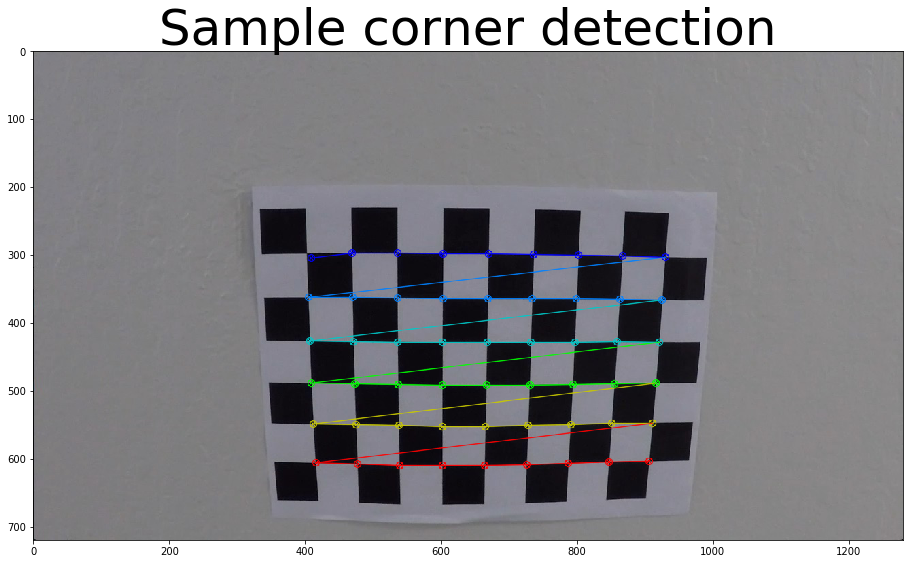

In [2]:
#number of corners in x and y axis 
nx = 9
ny = 6

#place holder for all detected 3D and 2D points
object_points = []
image_points = []

#preparing object points. these points are fixed
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

#loading images
fnames = glob.glob("camera_cal/calibration*.jpg")

#for each images finding the corner points
for fname in fnames:
    img = mpimg.imread(fname)
    #print(fname)
    #image_shape = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #RGB to gray conversion
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None) #finds corner
    if ret: 
        object_points.append(objp)
        image_points.append(corners)

cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

f, axs = plt.subplots(1, 1, figsize=(24, 9))
axs.imshow(img)
axs.set_title('Sample corner detection', fontsize=50)
#plt.show()

#print("Image size:",gray.shape[::-1])
#print(image_shape[:2])
#from all detected corner points and its actual image points camera calibration is performed
ret, camera_mat, dist_coeff, r_vecs, t_vecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1],None,None)
    

Using the generated camera matrix and distortion coefficients with opencv function 'undistort()' we can do distortion correction. Sample result is provided below:

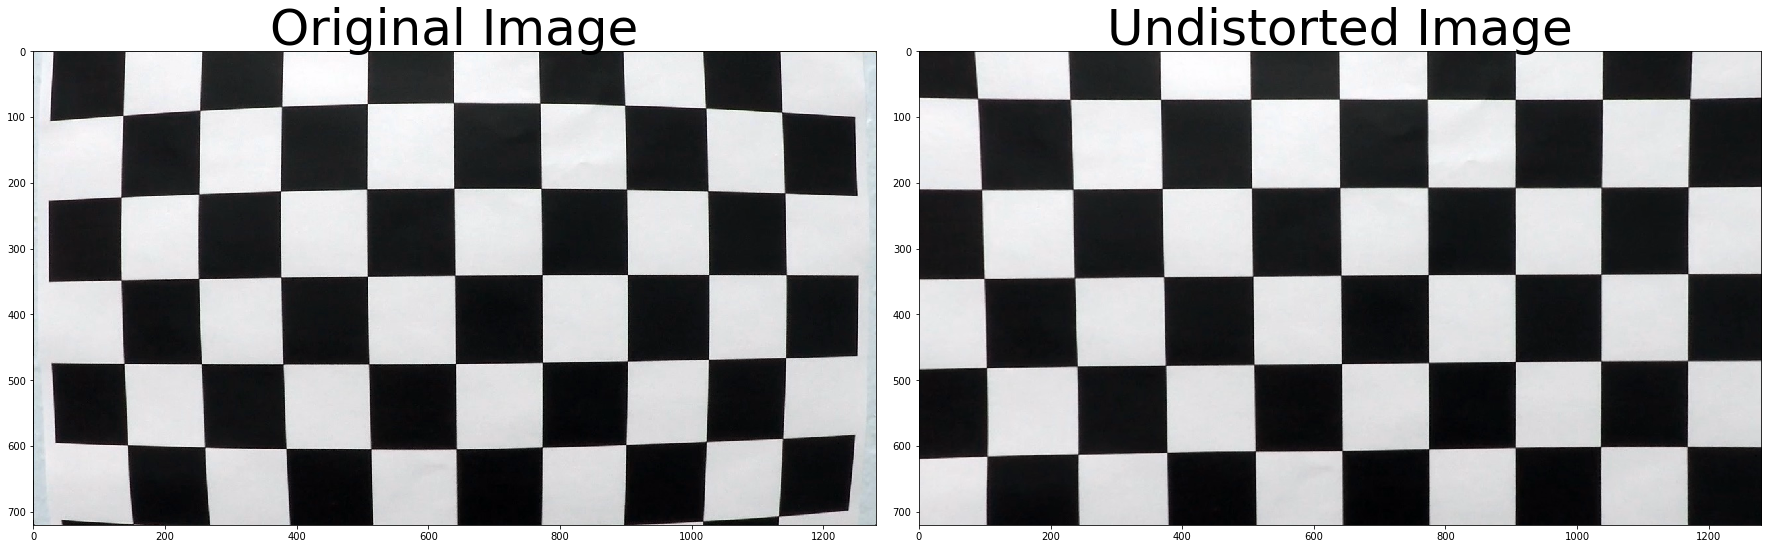

In [3]:
#load a sample image
img = cv2.imread('camera_cal/calibration1.jpg')
#perform undistortion using opencv
undistorted = cv2.undistort(img, camera_mat, dist_coeff, None, camera_mat)

#plotting the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline (Single image)

### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:

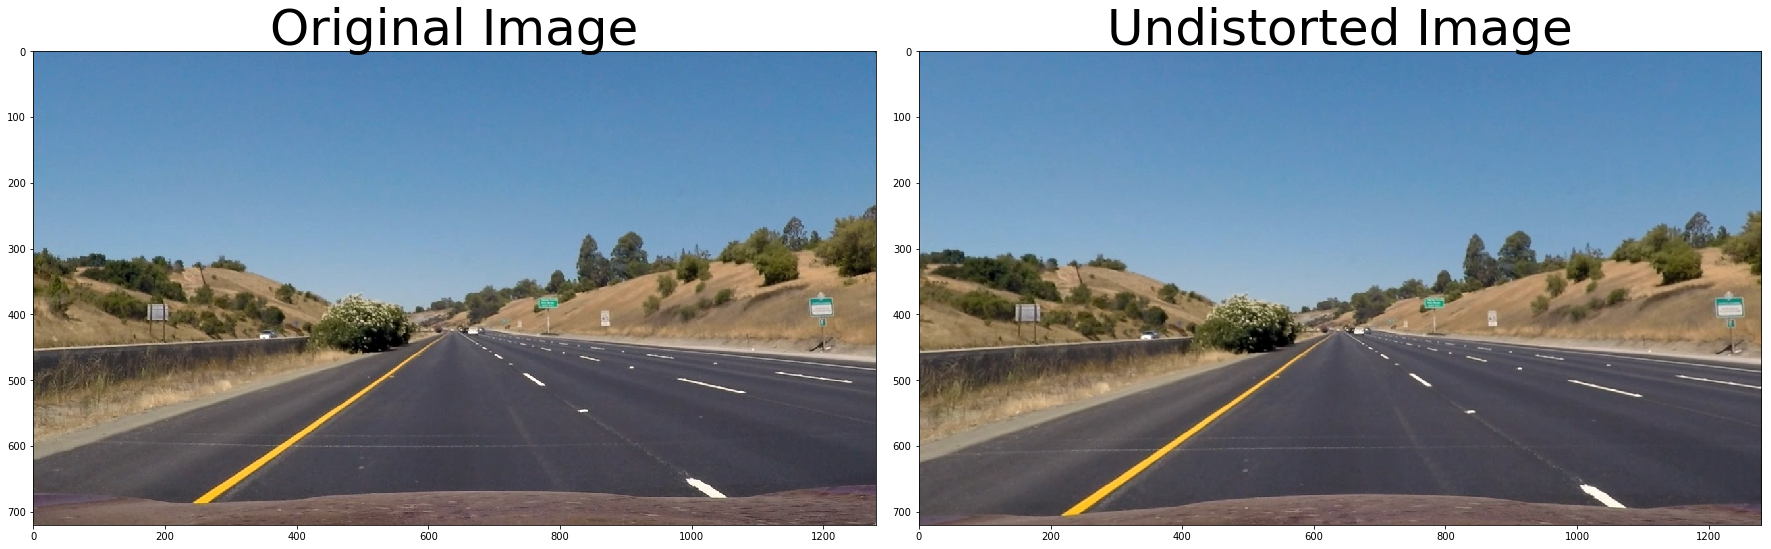

In [4]:
test1 = cv2.cvtColor(cv2.imread("test_images/straight_lines1.jpg"), cv2.COLOR_BGR2RGB)
undist_test1 = cv2.undistort(test1, camera_mat, dist_coeff, None, camera_mat)

#plotting the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_test1)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 2. Describe how you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image. The function 'threshold_img' given the below cell will call sobel, magnitude and direction gradient threshold. And the combined result of gradient threshold will again combine with s channel thershold image to generate the final output binary image. A region of interest based filtering also applied on the resultant binary image, inorder to remove unwanted areas.

In [5]:
# Functions created for soble, magnitude of gradients, direction of gradient and HLS based thresholding
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(gray)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_direction)
    binary_output[(grad_direction >= thresh[0]) & (grad_direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def showImages(images, cols = 4, rows = 5, figsize=(15, 10), cmap = None):
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.tight_layout()
    
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if len(image.shape) > 2:# cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap='gray')
            ax.set_title(imagePathName)
            ax.axis('off')
            
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
def threshold_img(image, display=True):
    
    height, width = undist_test1.shape[:2]

    # gradient threshold
    sx_binary = abs_sobel_thresh(image, 'x', sobel_kernel=7, thresh=(20, 100))
    sy_binary = abs_sobel_thresh(image, 'y', sobel_kernel=7, thresh=(80, 255))

    # gradient direction threshold
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

    # magnitude gradient threshold
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))

    # combine threshold
    combine_binary = np.zeros_like(dir_binary)
    combine_binary[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # color space - hls threshold
    s_binary = hls_select(image, thresh=(170, 255))

    # combine threshold
    color_binary = np.zeros_like(combine_binary)
    color_binary[(s_binary > 0) | (combine_binary > 0)] = 1

    # crop dst points
    left_bottom = (100, height)
    right_bottom = (width - 20, height)
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, height)
    inner_right_bottom = (1150, height)
    inner_apex1 = (700, 480)
    inner_apex2 = (650, 480)
    vertices = np.array([[left_bottom, apex1, apex2, 
                    right_bottom, inner_right_bottom, 
                    inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    
    mask = np.zeros_like(color_binary)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(color_binary, mask)

    if display:
        #plotting the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(masked_image, cmap='gray')
        ax2.set_title('Generated Binary Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return masked_image


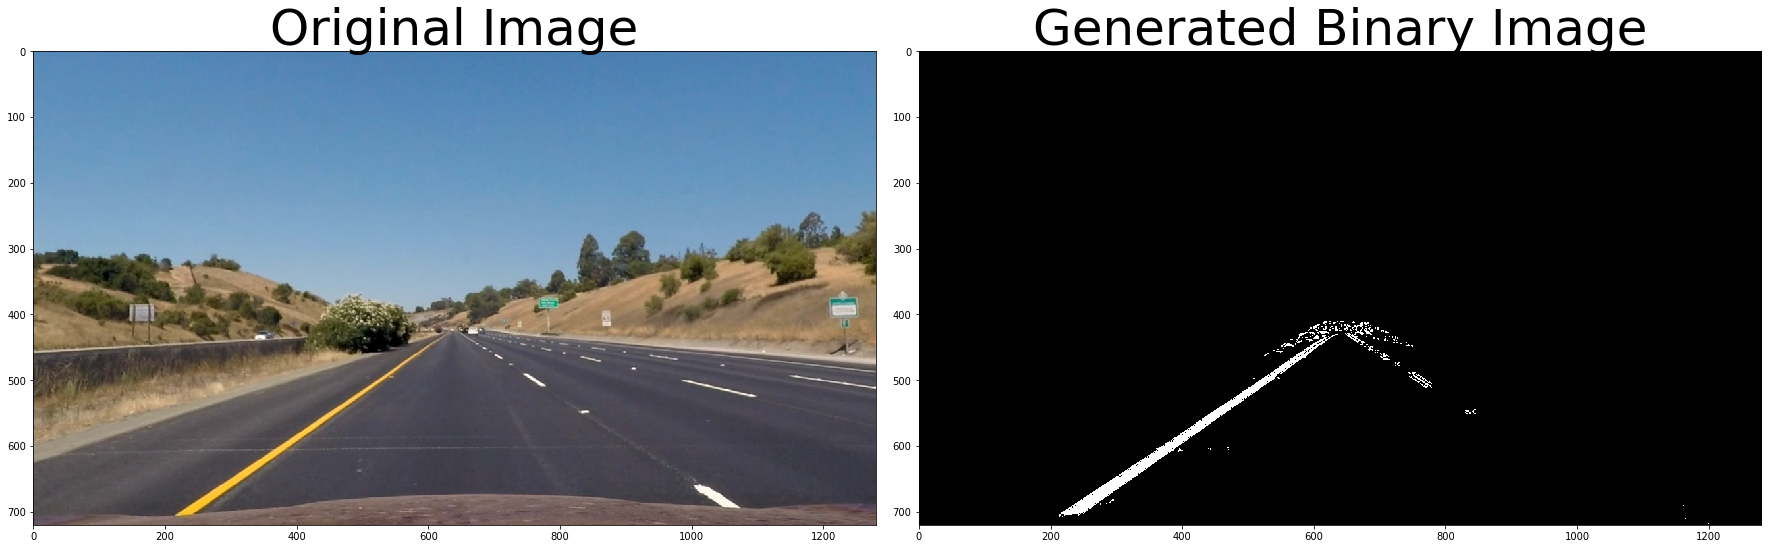

In [7]:
thresholded = threshold_img(undist_test1)

### 3. Describe how you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `perspective_transform()`. The `perspective_transform()` function takes inputs as an image (`img`), as well as source (`src`) and destination (`dst`) points and a boolean for inverse operation or not.  I chose the hardcode the source and destination points in the following manner:

```python
height, width = undist_test1.shape[:2]
offset = 200
src = np.float32([[200, 720], [580, 460], [710, 460], [1100, 720]])
dst = np.float32([[offset, height], [offset, 0], [width - offset, 0], [width - offset, height]])
```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 200, 720      | 200 , 720     | 
| 580, 460      | 200 , 0       |
| 710, 460      | 1080, 0       |
| 1100, 720     | 1080, 720     |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

In [8]:
def perspective_transform(image, src, dst, inverse=False):
    img_size = (image.shape[1], image.shape[0])
    if inverse:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)


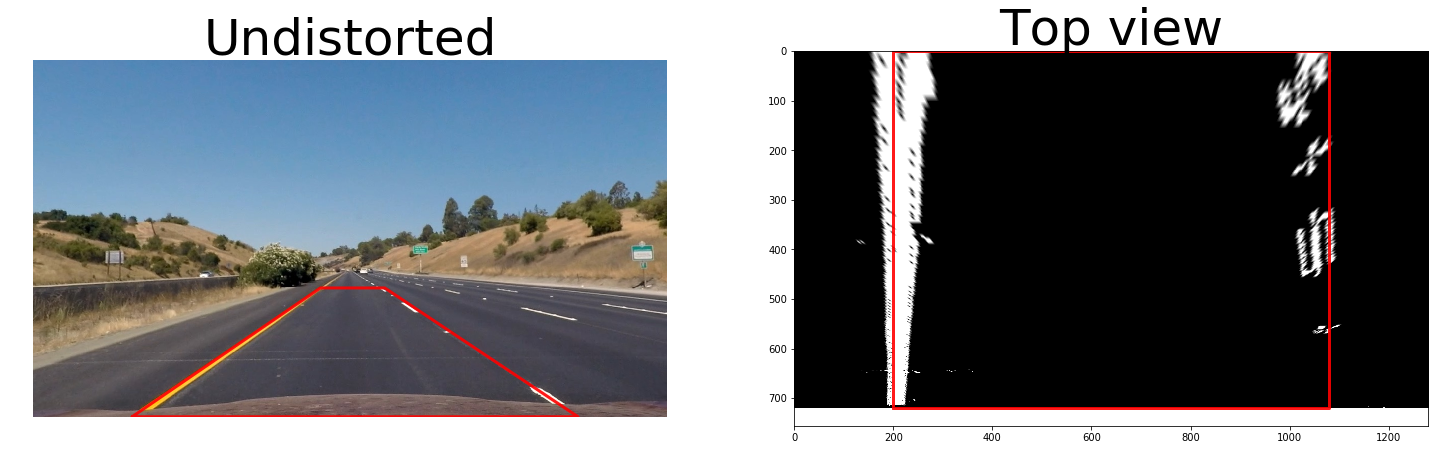

In [9]:

height, width = undist_test1.shape[:2]
offset = 200
src = np.float32([[200, 720], [580, 460], [710, 460], [1100, 720]])
dst = np.float32([[offset, height], [offset, 0], [width - offset, 0], [width - offset, height]])

top_view = perspective_transform(thresholded, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 20))
sx = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
sy = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
dx = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
dy = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]

ax1.imshow(undist_test1)
ax1.plot(sx, sy, color='#ff0000', alpha=0.9, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([height,0])
ax1.set_xlim([0,width])
ax1.set_title("Undistorted",fontsize=50)
ax1.axis('off')
#ax2.imshow(top_view)
ax2.imshow(top_view, cmap='gray')
ax2.plot(dx, dy, color='#ff0000', alpha=0.9, linewidth=3, solid_capstyle='round', zorder=2)
ax2.set_title("Top view", fontsize=50)
#ax2.axis('off')


### 4. Describe how you identified lane-line pixels and fit their positions with a polynomial?
First, I have used the histogram approach that has given in the tutorial to identify line positions in the image. This is implemented in the function find_line_base(), which takes top view image and returns the base x values of left and right lines.

Then I apply the sliding window search as provided in the tutorial to find the x and y positions of all non zero pixels. For this I have a function window_search() which also takes care the search around previous detected line points. The function returns left and right line points.

On the returned line points I apply a 2nd order polynomial equation to fit appropriate polynomials. fit_polynomial() is responsible for this and it will take care both left and right line points and returns the corresponding polynomials

In [10]:
def find_line_base(binary_warped):
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base

In [11]:
print("Line base points:",find_line_base(top_view))

Line base points: (208, 1055)


In [12]:
def window_search(binary_warped, left_lane, right_lane, nwindows=9, margin=100, minpix=50):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    leftx_base, rightx_base = find_line_base(binary_warped)
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #if not (left_lane.detected or right_lane.detected):
    if not (left_lane.detected or right_lane.detected):
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height
            win_y_high = binary_warped.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                          (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                          (0, 255, 0), 2)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    else:
        left_fit = left_lane.current_fit[-1]
        right_fit = right_lane.current_fit[-1]
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                          (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
        
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                           (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)# if len(leftx) != 0 else None
    right_fit = np.polyfit(righty, rightx, 2)# if len(rightx) != 0 else None
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

In [13]:
def fit_polynomial(binary_warped, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx

### 5. Describe how  you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

The radius of curvature is computed according to the formula and method described in the classroom material. Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.

The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [14]:
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def find_pos(l_fit, r_fit, w, h):
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    car_position = w / 2
    l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
    r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_dist

In [15]:
#high level polynomial fitting function
def fitLines(binary_warped, left_lane, right_lane):
       
    binary_warped[binary_warped > 0] = 255
    
    left_fit, right_fit, left_lane_inds, right_lane_inds = window_search(binary_warped, left_lane, right_lane)
    
    ploty, left_fitx, right_fitx = fit_polynomial(binary_warped, left_fit, right_fit)

    left_curverad = find_curvature(ploty, left_fitx)
    right_curverad = find_curvature(ploty, right_fitx)

    left_lane.add_line(left_fit, left_lane_inds)
    right_lane.add_line(right_fit, right_lane_inds)

    return left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds, left_curverad, right_curverad



In [16]:
#Following two are visualization functions
def visualizeLines(binary_warped, left_lane_inds, right_lane_inds):
    # Generate x and y values for plotting
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img

def visualizeLanes(undist, binary_warped, left_fitx, right_fitx, left_fit, right_fit, left_curve, right_curve):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    # newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    #newwarp = unwarp_image(color_warp)
    newwarp = perspective_transform(color_warp, src, dst, inverse=True)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Put text on an image
    curvature = int((left_curve + right_curve) / 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(curvature)
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    # Find the position of the car
    #pts = np.argwhere(newwarp[:,:,1])
    #position = find_position(pts, undist.shape[1])
    h, w = binary_warped.shape[:2]
    position = find_pos(left_fit, right_fit, w, h)
    text = "Offset from center: {:.2f} m".format(position)
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    
    # plt.imshow(result)
    return result

#### Complete Pipeline

In [17]:
diag = False
def process_image(image, display=False):
    # Undistort image 
    undist = cv2.undistort(image, camera_mat, dist_coeff, None, camera_mat)
    
    # Apply threshold schemes to extract Lanes
    threshold = threshold_img(image, False)
    
    # Perspective Transform to view top-down view of lanes
    offset = 200
    src = np.float32([[200, 720], [580, 460], [710, 460], [1100, 720]])
    dst = np.float32([[offset, height], [offset, 0], [width - offset, 0], [width - offset, height]])
    warped = perspective_transform(threshold, src, dst)
    
    # fit Lane Lines on top-down view of lanes
    lfx, rfx, lf, rf, l_ind, r_ind, lc, rc = fitLines(warped, left_lane, right_lane)
    
    # visualize lane lines on top-down view of lanes
    lanes_img = visualizeLines(warped, l_ind, r_ind)
    
    # Visualize lane lines on undistorted image 2D view
    result = visualizeLanes(undist, warped, lfx, rfx, lf, rf, lc, rc)
    
    if diag:
        threshold[threshold > 0] = 255
        thresh_3_channel = np.dstack((threshold, threshold, threshold))
        result1 = np.hstack((undist, result, ))
        result2 = np.hstack((thresh_3_channel, lanes_img))
        result = np.vstack((result1, result2))
    
    if display:
        #plotting the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(undist)
        ax1.set_title('Input Image', fontsize=50)
        ax2.imshow(result)
        ax2.set_title('Result Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return result

In [18]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #number of detected pixels
        self.pix_count = None
        
    def add_line(self, fit, inds):
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit - self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100. and len(self.current_fit) > 5):
                self.detected = False
            else:
                self.detected = True
                self.pix_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit) - 5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit) - 1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)

### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly

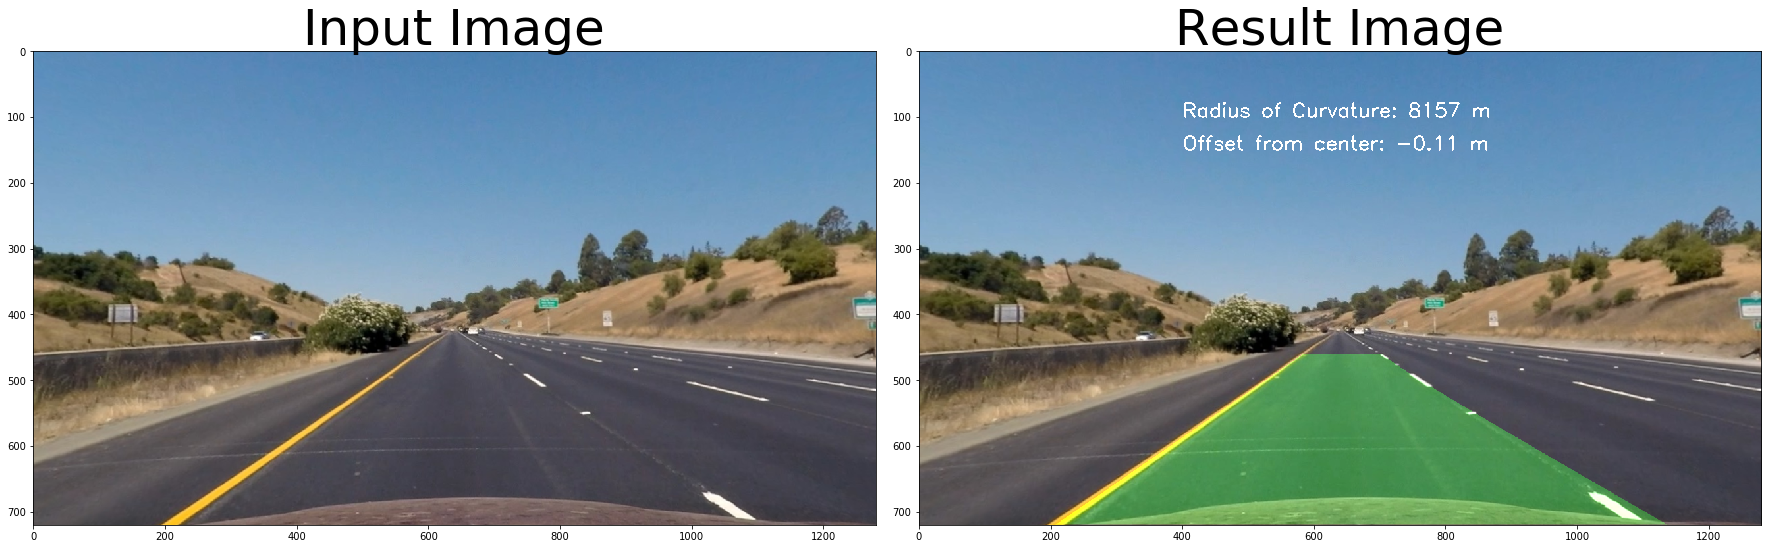

In [19]:
left_lane = Line()
right_lane = Line()
vis_in = process_image(undist_test1, display=True)

## Pipeline (video)

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
#Video creation
left_lane = Line()
right_lane = Line()
diag = False
video_output1 = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
result_clip1 = clip1.fl_image(process_image)

%time result_clip1.write_videofile(video_output1, audio=False)

### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

In [22]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="result.mp4" type="video/mp4">
</video></div>""")

#### Here's a [link to my video result](./result.mp4) in case the above html interface is not working.

## Discussion

### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Noice like white objects or similar light color object in the road will affect in the polynomial if we are not able to restrict the search space. By window search we are some how achiving this. But I feel like if there are other lane like features in the road, like a white car close to the ego vehicle, the algorithm may fail.

Future Improvements:
1. Currently we are considering only the ego lane. The algorithm should capable to detect multiple lanes. Also by fusing road information like road width and number of lanes we can restrict false detections.

2. Also by fusing road information like road width and number of lanes we can restrict false detections.

3. CNN based detections can be considered over histogram and gradient based segmentation
